In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


**Import Dependencies, Framework and Libraries**

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, dataloader
from torchvision import datasets

from pathlib import Path
from torch import optim
#!pip install torchmetrics
from torchmetrics import Accuracy, Precision, F1Score

**Get Data of Agricultural Products **

In [3]:
dir_path = Path('Agricultural-crops')
dir_path

WindowsPath('Agricultural-crops')

In [4]:
##Transform Data
from torchvision import transforms
transformer = torchvision.transforms.Compose([
    transforms.Resize(size = (224, 224)),
    transforms.ToTensor(),
])

In [5]:
##Load Image to Dataset 
datafolder = torchvision.datasets.ImageFolder(dir_path, transform = transformer)
len(datafolder)

829

In [6]:
classes = datafolder.classes
classes[0]

'Cherry'

In [7]:
# Load a Sample
img, label = datafolder[10]

In [8]:
# Sample Details
img.shape, label

(torch.Size([3, 224, 224]), 0)

torch.Size([224, 224, 3])


Text(0.5, 1.0, 'Cherry')

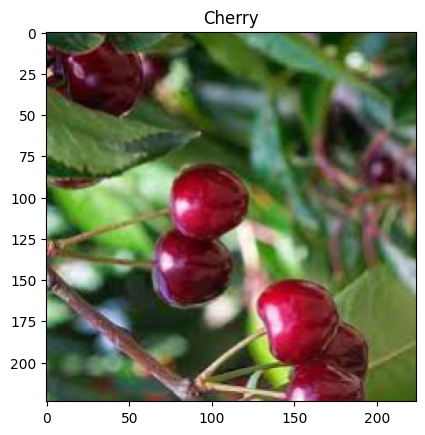

In [9]:
import matplotlib.pyplot as plt
img_sample = img.permute(2, 1, 0)
print(img_sample.shape)
plt.imshow(img_sample)
plt.title(classes[label])

In [10]:
# set up device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [11]:
import torch.utils.data as data

# Random split
train_set_size = int(len(datafolder) * 0.8)
valid_set_size = len(datafolder) - train_set_size
train_set, valid_set = data.random_split(datafolder, [train_set_size, valid_set_size])

In [12]:
## lenghth of Sets
len(train_set), len(valid_set)

(663, 166)

In [13]:
torch.__version__

'2.0.1+cpu'

In [14]:
from torchvision import models
import torchvision.models.efficientnet as e
import torchvision.models.resnet as r

In [15]:
#Load Weights for Training
WEIGHTS = r.resnet50(pretrained= True)
#WEIGHTS = e.efficientnet_b0(pretrained= True)

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
WEIGHTS.state_dict

<bound method Module.state_dict of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 2

In [17]:
for p in WEIGHTS.parameters():
    p.requires_grad = False

In [18]:
WEIGHTS.fc = nn.Linear(2048, 30)
#WEIGHTS.fc = nn.Linear(1280, 30)

In [19]:
WEIGHTS.fc

Linear(in_features=2048, out_features=30, bias=True)

In [20]:
from torch.utils.data import DataLoader
BATCH_SIZE = 30
train_loader = DataLoader(dataset= train_set, batch_size= BATCH_SIZE, shuffle= True)
val_loader = DataLoader(dataset= valid_set, batch_size = BATCH_SIZE)

##Evaluation Metrics/ Loss Function / Optimizers

In [21]:
model = WEIGHTS

In [22]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [25]:
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr= 0.01)
accuracy_fn = Accuracy(task='multiclass', num_classes=30).to(device)
F1_fn = F1Score(task='multiclass', num_classes=30).to(device)

In [26]:
EPOCHS = 5

train_losses, train_acc = 0, 0

model.train()
for epoch in range(EPOCHS):
  for batch, (X, y )in enumerate(train_loader):
    X = X.to(device)
    y = y.to(device)

    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_acc += F1_fn(y_pred.argmax(dim=1), y)
    train_losses += loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_losses /= len(train_loader)
  train_acc /= len(train_loader)
  print(f' Train Loss: {train_losses:.4f} | Train F1_Score: {train_acc:.3f}')

#model.eval()
test_loss, test_acc = 0, 0
with torch.inference_mode():
    for Xt, yt in val_loader:
        Xt = Xt.to(device)
        yt= yt.to(device)
        test_pred = model(X)
        t_loss = loss_fn(test_pred, y)
        test_loss += t_loss
        test_acc += F1_fn(test_pred.argmax(dim=1), y)
    test_loss /= len(val_loader)
    test_acc /= len(val_loader)
    
    print(f' Test Loss {test_loss:.4f} | Test F1_Score: {test_acc:.3f}')


 Train Loss: 2.3619 | Train F1_Score: 0.655
 Train Loss: 1.3413 | Train F1_Score: 0.772
 Train Loss: 0.8121 | Train F1_Score: 0.873
 Train Loss: 0.6855 | Train F1_Score: 0.890
 Train Loss: 0.5685 | Train F1_Score: 0.907
 Test Loss 0.0008 | Test F1_Score: 1.000


In [80]:
import tkinter as tk
from PIL import Image, ImageTk
from tkinter import filedialog

In [81]:
# Create a window
window = tk.Tk()

In [82]:
# Image view and load
def load_image(file_path):
    if file_path:
        image = Image.open(file_path)
        image = image.resize((224, 224))
        photo = ImageTk.PhotoImage(image)
        image_label.configure(image=photo)
        image_label.image = photo

In [83]:
image_label = tk.Label(window)
image_label.pack()

In [84]:
# Model predict with new image
def predict():

    file_path = filedialog.askopenfilename()

    if file_path:
        load_image(file_path=file_path)
        input_image = Image.open(file_path)
        transformed_image = transformer(input_image)
        transformed_image = transformed_image.unsqueeze(0) 
        model.eval()
        output = model(transformed_image)

        predicted_label = output.argmax().item()
        predicted_class = classes[predicted_label]

        result_label = tk.Label(window, text=f"Prediction: {predicted_class}")
        result_label.pack()

In [85]:
predict_button = tk.Button(window, text="Predict", command=predict)
predict_button.pack()

In [86]:
window.mainloop()